# Analysis of Meps data

Data is provided by MET Norway through thredds.met.no. The spatial resolution is either 2.5 or 0.5 km which is regridded to 1 km using Fimex.

### Imports and setup

In [5]:
# ensure loading of APS modules
import sys, os
sys.path.append(r'C:\Users\kmu\PycharmProjects\APS')
print(sys.path)

['C:\\Users\\kmu\\PycharmProjects\\APS\\aps\\notebooks', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\python38.zip', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\DLLs', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib', 'C:\\ProgramData\\Anaconda3\\envs\\scientific', '', 'C:\\Users\\kmu\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\Pythonwin', 'C:\\ProgramData\\Anaconda3\\envs\\scientific\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\kmu\\.ipython', 'D:\\Dev\\APS', 'D:\\Dev\\APS', 'C:\\Users\\kmu\\PycharmProjects\\APS']


In [6]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-notebook')
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

import datetime
import numpy as np
import netCDF4

import warnings
warnings.filterwarnings("ignore")

from aps.load_region import load_region, clip_region
from aps.analysis import describe

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Numpy version: ', np.__version__)
print('Matplotlib version: ', matplotlib.__version__)
print('Today: ', datetime.date.today())

Python version: 3.8.1 (default, Mar  2 2020, 13:06:26) [MSC v.1916 64 bit (AMD64)]
Numpy version:  1.18.1
Matplotlib version:  3.1.3
Today:  2021-08-10


In [7]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3007)

Missing value: -32768


### Cloud area fractions from meps_det_pp

Only variable "cloud_fraction" is contained in the default NVE extraction meps_det_pp...nc.

In [9]:
nc_kmu = netCDF4.Dataset(r"\\hdata\grid\tmp\kmu\meps\meps_det_pp_1km_2018012406.nc", "r")

time_v = nc_kmu.variables['time']

# Choose a time-step
t_index = 6
# Choose a pressure level (if applicable)
p_index = 12 # 12=1000hPa, 11=925hPa, 10=850hPa, ..., 7=500hPa, ..., 0=50hPa in arome_metcoop_test

ts = netCDF4.num2date(time_v[t_index], time_v.units)
print(ts)

2018-01-24 12:00:00


In [10]:
# clouds
cloud_cover = clip_region(nc_kmu.variables['cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)
low_clouds = clip_region(nc_kmu.variables['low_type_cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)
medium_clouds = clip_region(nc_kmu.variables['medium_type_cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)
high_clouds = clip_region(nc_kmu.variables['high_type_cloud_area_fraction'], region_mask, t_index, y_min, y_max, x_min, x_max)

print(cloud_cover.shape, nc_kmu.variables['cloud_area_fraction'].shape)

(171, 141) (67, 1550, 1195)


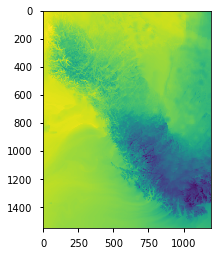

In [11]:
plt.imshow(nc_kmu.variables['air_temperature_2m'][t_index, 0,:,:])

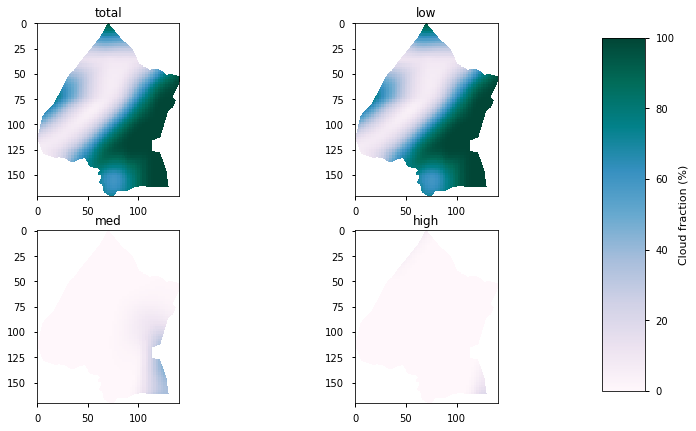

In [12]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))

colormap = plt.cm.PuBuGn

for ax, data, tle in zip(axes.flat,
                         [cloud_cover, low_clouds, medium_clouds, high_clouds],
                         ["total", "low", "med", "high"]):
    im = ax.imshow(data, cmap=colormap, vmin=0, vmax=100)
    ax.set_title(tle)
    

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cb = f.colorbar(im, cax=cbar_ax)
cb.set_label('Cloud fraction (%)')

plt.show()

In [13]:
a = np.cumsum(cloud_cover)[-1] / cloud_cover.size
print("{0:.2f} cloud cover at {1}".format(a, ts))

nan cloud cover at 2018-01-24 12:00:00


## APS freezing level

In [14]:
air_temperature = clip_region(nc_kmu.variables['air_temperature_2m'], region_mask, t_index, y_min, y_max, x_min, x_max)
altitude = clip_region(nc_kmu.variables['altitude'], region_mask, t_index, y_min, y_max, x_min, x_max)

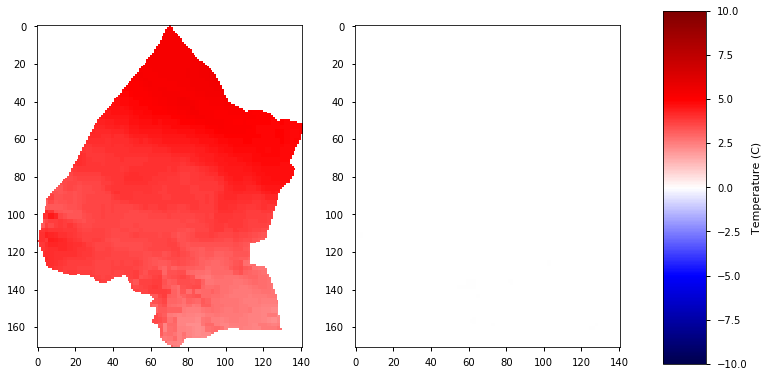

In [15]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

im1 = ax1.imshow(air_temperature-273.15, cmap=plt.cm.seismic, vmin=-10, vmax=10)
im2 = ax2.imshow(altitude, cmap=plt.cm.Greys, vmin=0, vmax=2500)

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cb = f.colorbar(im1, cax=cbar_ax)
cb.set_label('Temperature (C)')

plt.show()

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]] (171, 141) <class 'numpy.ma.core.MaskedArray'>


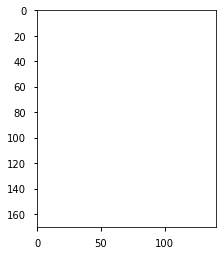

In [16]:
fl = altitude[air_temperature>272.65]
alt = np.ma.masked_where(air_temperature<272.65, altitude)
fl = np.ma.masked_where(air_temperature>273.65, alt)
print(fl, fl.shape, type(fl))

plt.imshow(fl, vmin=0, vmax=1500)

nan
0 :  nan
5 :  nan
25 :  nan
50 :  nan
75 :  nan
95 :  nan
100 :  nan


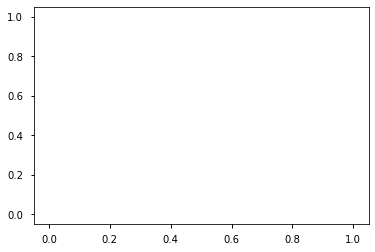

In [17]:
plt.plot(fl.flatten())
print(np.mean(fl.flatten()))
for p in [0,5,25,50,75,95,100]:
    print(p, ": ", np.percentile(fl.flatten(), p))

## Test local monitoring regions

In [18]:
region_mask, y_min, y_max, x_min, x_max = load_region(4001, local=True)

In [19]:
TA = clip_region(nc_kmu.variables['air_temperature_2m'], region_mask, t_index, y_min, y_max, x_min, x_max)
alt = clip_region(nc_kmu.variables['altitude'], region_mask, t_index, y_min, y_max, x_min, x_max)

print(describe(TA))
print(describe(alt))

The array is of shape (20, 20)
The median is 276.79
The first and third quartiles are 276.75 and 276.83
The minimum is 276.58 and the maximum is 276.89.

The array is of shape (20, 20)
The median is 0.07
The first and third quartiles are -0.41 and 0.48
The minimum is -1.21 and the maximum is 1.09.



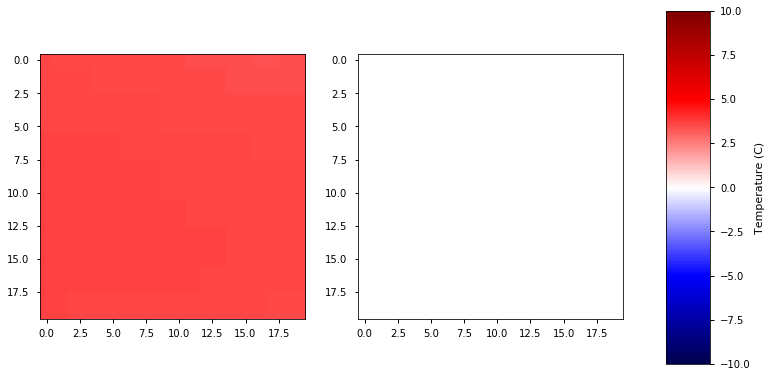

In [20]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,7))

im1 = ax1.imshow(TA-273.15, cmap=plt.cm.seismic, vmin=-10, vmax=10)
im2 = ax2.imshow(alt, cmap=plt.cm.Greys, vmin=0, vmax=2500)

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cb = f.colorbar(im1, cax=cbar_ax)
cb.set_label('Temperature (C)')

plt.show()

In [21]:
nc_kmu.close()

## Test alternative data on freezing level from meps_det_extracted

We can use the 0-degree isotherm layer. But it has "no data" where the 0-degree altidute is below the terrain elevation.
We can use the wet bulb which should give the correct temperature where the humidity is 100% (say precipitation).
However, values where relative humidity is low can diverge substantially - the wet bulb can be 5 to 10 degree Kelvin/Celsius lower. Thus corresponding to 500 to 1500 meters difference :-(


In [8]:
nc_ex = netCDF4.Dataset(r"\\hdata\grid\tmp\kmu\meps\meps_det_extracted_1km_latest.nc", "r")

time_v_ex = nc_ex.variables['time']
# Choose a time-step
t_index = 6
# Choose a pressure level (if applicable)
p_index = 12 # 12=1000hPa, 11=925hPa, 10=850hPa, ..., 7=500hPa, ..., 0=50hPa in arome_metcoop_test

y_dim = nc_ex.dimensions['y'].size

ts = netCDF4.num2date(time_v_ex[t_index], time_v_ex.units)
print(ts)

2018-01-25 12:00:00


In [9]:
isot = clip_region(nc_ex.variables['altitude_of_0_degree_isotherm'], region_mask, t_index, y_min, y_max, x_min, x_max)
print(np.median(isot),np.mean(isot),np.min(isot),np.max(isot), np.nanpercentile(isot, 95))

nan nan nan nan 926.8700561523438


In [10]:
isot = nc_ex.variables['altitude_of_0_degree_isotherm'][t_index, 0,:,:]
print(np.median(isot),np.mean(isot),np.min(isot),np.max(isot), np.nanpercentile(isot, 95))

769.5575561523438 538.737881572334 -22.004944 1387.3701 9.969209968386869e+36


218.58423 78.06346 -2216.1658 940.2092 218.584228515625 731.959228515625


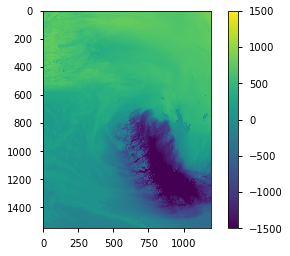

In [11]:
wetb = nc_ex.variables['altitude_of_isoTprimW_equal_0'][t_index, 0, :, :]
print(np.median(wetb),np.mean(wetb),np.min(wetb),np.max(wetb), np.percentile(wetb, 50), np.nanpercentile(wetb, 95))
plt.imshow(wetb, vmin=-1500, vmax=1500)
plt.colorbar()


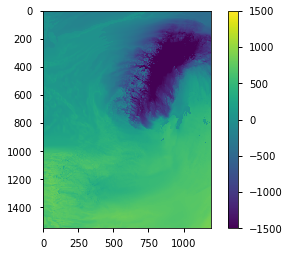

In [12]:
plt.imshow(np.flipud(wetb), vmin=-1500, vmax=1500)
plt.colorbar()

Missing value: -32768
687.271728515625 677.8849467098795 377.709228515625 837.209228515625 687.271728515625 779.459228515625


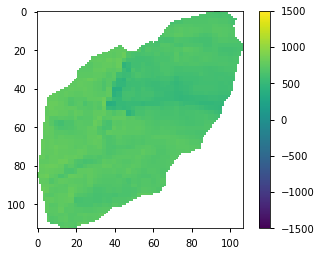

In [18]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3034)

#wetb_clip = clip_region(nc_ex.variables['altitude_of_isoTprimW_equal_0'], region_mask, t_index, y_min, y_max, x_min, x_max)
wetb_clip = region_mask * np.flipud(nc_ex.variables['altitude_of_isoTprimW_equal_0'][t_index, 0, (y_dim-y_max):(y_dim-y_min), x_min:x_max])
print(np.nanmedian(wetb_clip),np.nanmean(wetb_clip),np.nanmin(wetb_clip),np.nanmax(wetb_clip), np.nanpercentile(wetb_clip, 50), np.nanpercentile(wetb_clip, 95))

plt.imshow(wetb_clip, vmin=-1500, vmax=1500)
plt.colorbar();

#TODO: Currently wrong - 3007 Vest-Finnmark should be blue - flip up-down
# I updated with y_dim-y_max:y_dim-y_min - should be correct now, but check

Missing value: -32768
	 1 0 0 2018-01-25 06:00:00 661.97265625 664.6854516709749
	 2 0 1 2018-01-25 07:00:00 688.634765625 684.8163879785204
	 3 0 2 2018-01-25 08:00:00 654.42626953125 649.1012910723628
	 4 0 3 2018-01-25 09:00:00 637.2099609375 634.6847424490707
	 5 0 4 2018-01-25 10:00:00 631.711181640625 627.2749894938993
	 6 0 5 2018-01-25 11:00:00 610.548095703125 605.3083123451732
647.4171549479166
	 1 6 6 2018-01-25 12:00:00 599.209228515625 599.4229779001646
	 2 6 7 2018-01-25 13:00:00 601.742919921875 601.6758655151788
	 3 6 8 2018-01-25 14:00:00 582.234375 585.3584671959626
	 4 6 9 2018-01-25 15:00:00 575.765869140625 568.2207328161543
	 5 6 10 2018-01-25 16:00:00 544.71142578125 529.9772277261047
	 6 6 11 2018-01-25 17:00:00 475.68994140625 476.97525344465475
563.2256266276041
	 1 12 12 2018-01-25 18:00:00 448.093994140625 449.6535399308761
	 2 12 13 2018-01-25 19:00:00 434.514404296875 430.07176520283264
	 3 12 14 2018-01-25 20:00:00 411.107177734375 401.3541927516079
	 4 1

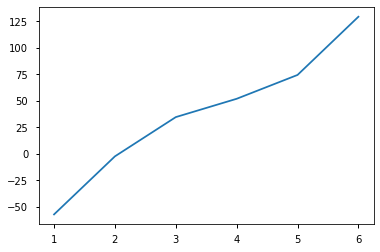

In [40]:
# Load region mask - only for data on 1km xgeo-grid
region_mask, y_min, y_max, x_min, x_max = load_region(3024)


for k, f in enumerate(range(0, 60, 6), start=1):
    t = []
    sl = []
    for i, d in enumerate(range(f, f+6), start=1):
        wetb_clip = region_mask * np.flipud(nc_ex.variables['altitude_of_isoTprimW_equal_0'][d, 0, (y_dim-y_max):(y_dim-y_min), x_min:x_max])
        _t = netCDF4.num2date(time_v_ex[d], time_v_ex.units)
        _sl = np.nanmedian(wetb_clip)
        print("\t", i, f, d, _t, _sl, np.nanmean(wetb_clip))
        t.append(i)
        sl.append(_sl)

    sl = np.array(sl)
    print(np.mean(sl))
plt.plot(t, sl);

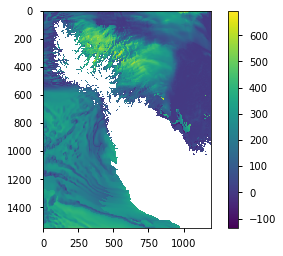

In [15]:
plt.imshow(isot-wetb)
plt.colorbar()

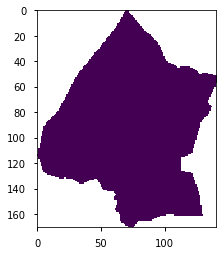

In [16]:
plt.imshow(region_mask)

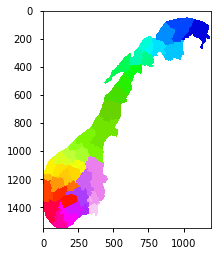

In [17]:
_vr = netCDF4.Dataset(r"../data/terrain_parameters/VarslingsOmr_2017.nc", "r")
_regions = _vr.variables["VarslingsOmr_2017"][:]

plt.imshow(_regions, vmin=3000, vmax=3048, cmap=plt.get_cmap('gist_ncar'))

Vi angi jo temperaturen. Så det er egentlig kun snøfallgrense som er relevant og ikke nullgradersgrense som må være med.

Så i stedet for

*5 mm i døgnet, opp mot 12 mm i mest utsatt område.Liten kuling fra vest.-8 °C til -2 °C på 1100 moh.Plussgrader opp til 500 moh om ettermiddagen.
Skyet.*

kan vi skrive

*5 mm i døgnet, opp mot 12 mm i mest utsatt område. Regn opp til 500 moh om ettermiddagen. Liten kuling fra vest.-8 °C til -2 °C på 1100 moh. Skyet.*

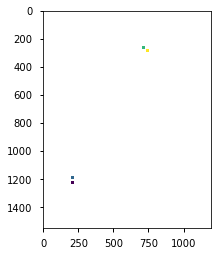

In [31]:
_local = _vr.variables["LokalOmr_2018"][:]
plt.imshow(_local)